In [1]:
! pip install torchdiffeq

In [1]:
import sys
sys.path.append("../")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import models.stribor_lib as st
import torch
import numpy as np
from tqdm import tqdm

/opt/homebrew/Caskroom/miniforge/base/envs/torch-mps/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set flow models for jets

In [32]:
device = 'cpu'  # ['cuda', 'cpu', or 'mps']

## Define set flow model

Load model from https://arxiv.org/abs/2010.03242

In [33]:
def get_exact_model(dim, hidden_dims, latent_dim, context_dim=0, n_transforms=4, set_data=False, device='mps', atol=1e-4):
    
    has_latent = True if context_dim > 0 else False
    
    transforms = []
    
    for _ in range(n_transforms):
        transforms.append(st.ContinuousNormalizingFlow(dim, net=st.net.DiffeqExactTraceAttention(dim, hidden_dims, dim, d_h=latent_dim, latent_dim=context_dim).to(device),
                                            divergence='exact', solver='dopri5', atol=atol, has_latent=has_latent, set_data=set_data).to(device))
        
    model = st.Flow(st.Normal(torch.zeros(dim).to(device), torch.ones(dim).to(device)), transforms).to(device)
    
    return model

## Jets

In [34]:
# Data from https://zenodo.org/record/4834876#.Y0UkO-xBzzc
q_jets = np.genfromtxt("../data/q_jets.csv")

In [35]:
from einops import rearrange

q_jets_rearranged = rearrange(q_jets, "N (particles properties) -> N particles properties", particles=30)

In [36]:
model = get_exact_model(dim=3, hidden_dims=[64, 64], latent_dim=8, context_dim=0, n_transforms=3, 
                        set_data=True, device=device, atol=1e-4)

In [37]:
x = torch.Tensor(q_jets_rearranged[:, :, :3]).to(device)
mask = torch.Tensor(q_jets_rearranged[:, :, 3:]).to(device)

mask[mask > 0] = 1
mask[mask < 0] = 0

In [38]:
x.shape

torch.Size([170679, 30, 3])

In [39]:
model.log_prob(torch.Tensor(x[:64]), mask=mask[:64]).sum()  # Test

tensor(-4511.1963, grad_fn=<SumBackward0>)

In [72]:
def train_flow(dataset, mask, params, batch_size=128, n_steps=512, lr=4e-5):
    """ Convenience function for training the normalizing flow transformation
    """
    optimizer = torch.optim.AdamW(params, lr=lr)
    
    # Run specified number of optimization steps
    for i_step in tqdm(range(n_steps)):
        
        optimizer.zero_grad()
        
        # Draw random batches and compute their log-probability
        idxs = torch.Tensor(np.random.choice(dataset.shape[0], batch_size)).to(torch.int64)
        
        dataset_batch = dataset[idxs,:]
        mask_batch = mask[idxs,:]
        
        loss = -model.log_prob(dataset_batch).mean()
        
        loss.backward()
        optimizer.step()

        if i_step % 10 == 0: print('Step: {}; Loss: {}'.format(i_step, loss.item()))

In [74]:
train_flow(x, mask, model.parameters(), n_steps=256)

In [69]:
# Get cardinality distribution from training data
unique, counts = np.unique((mask[:, :, -1].sum(-1)), return_counts=True)  

In [76]:
model.eval();

100%|███████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.64it/s]


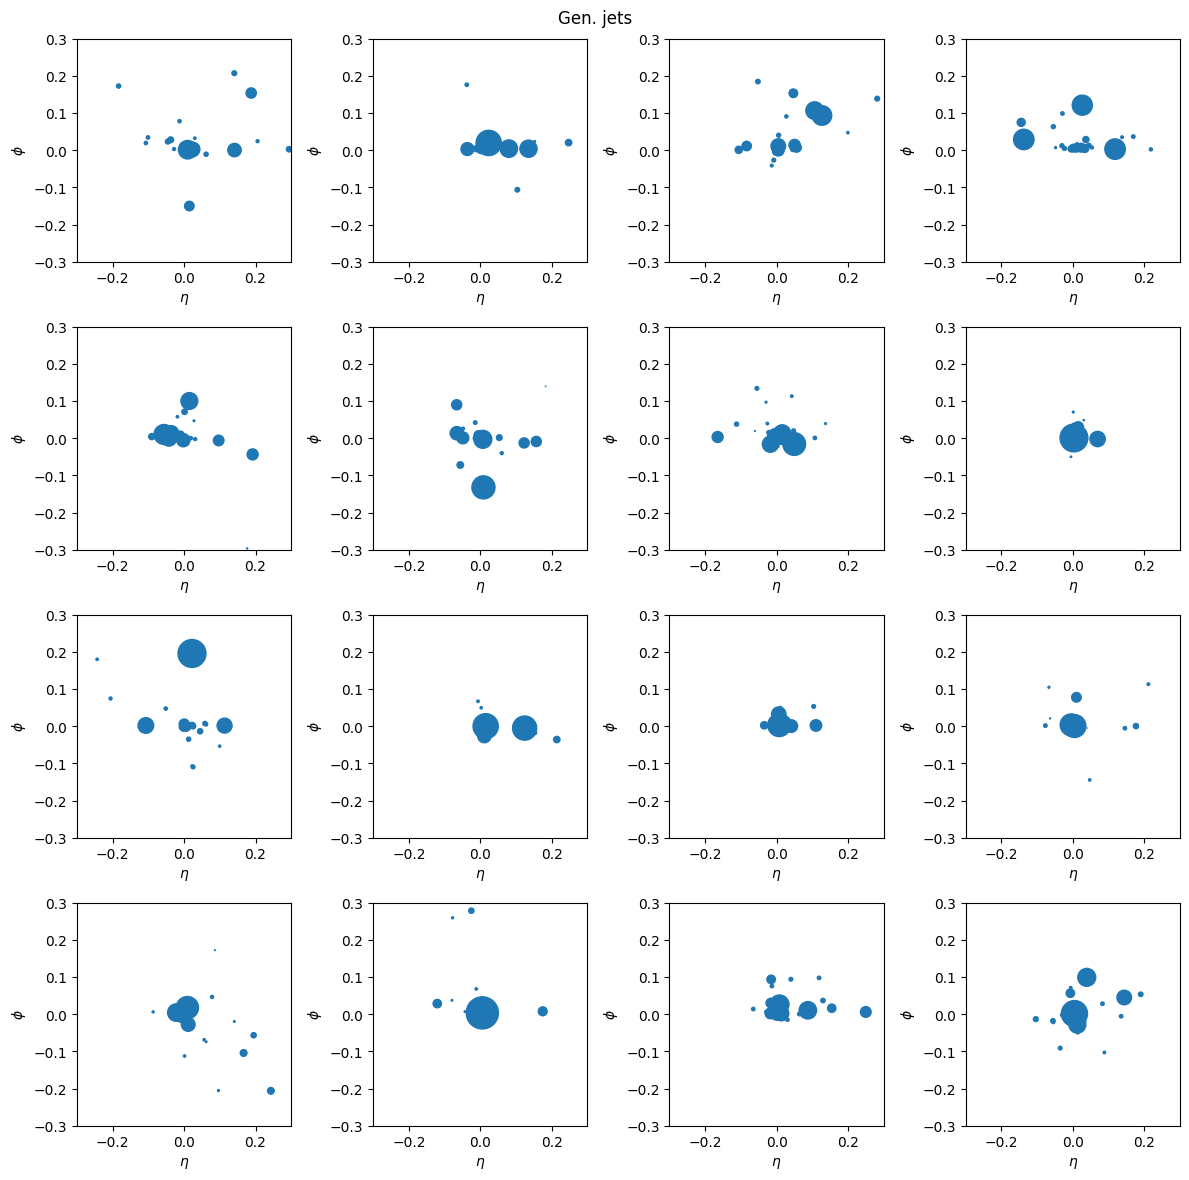

In [119]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(12, 12))
gs = GridSpec(4, 4)

for i in tqdm(range(16)):
    
    ax = fig.add_subplot(gs[i])

    n_particles = int(np.random.choice(unique, p=counts / np.sum(counts)))
    
    # Manual cut to exclude crappy samples?
    x_sample = np.array([[0.]])
    while x_sample[:, -1].sum() > 1.1 or x_sample[:, -1].sum() < 0.9:
        x_sample = np.array(model.sample(num_samples=(n_particles)).detach())
    
    ax.scatter(*x_sample[:, :2].T, s=1000 * np.abs(x_sample[:, 2]))  # Hacky np.abs!!
            
    ax.set_xlabel(r"$\eta$")
    ax.set_ylabel(r"$\phi$")
    
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    
plt.suptitle("Gen. jets")
plt.tight_layout()

100%|██████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 192.36it/s]


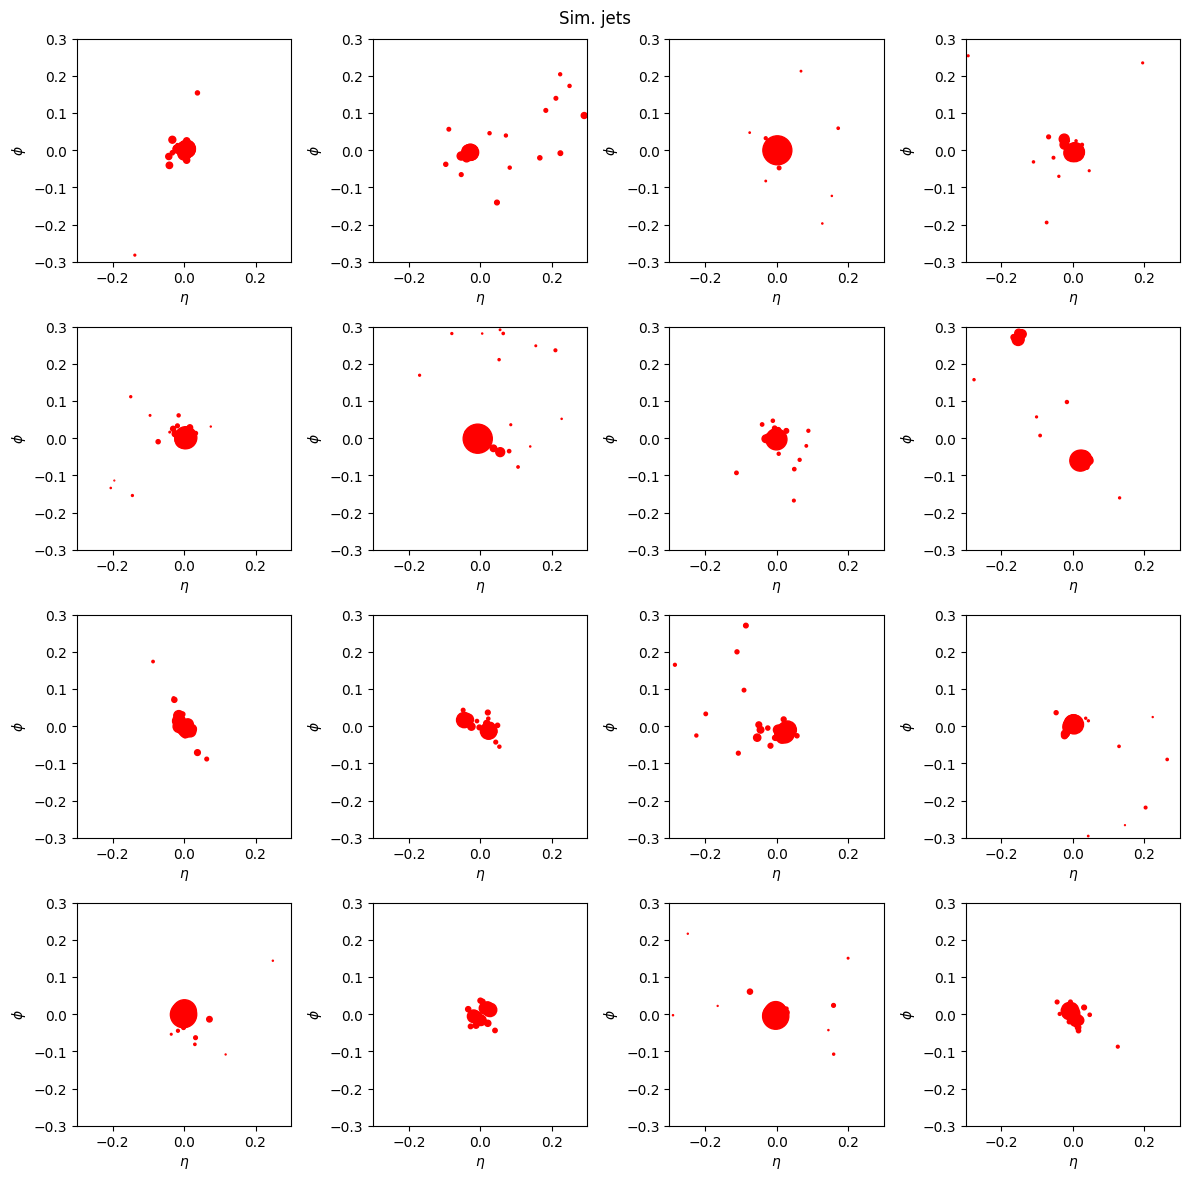

In [118]:
fig = plt.figure(figsize=(12, 12))
gs = GridSpec(4, 4)

for i in tqdm(range(16)):
    
    ax = fig.add_subplot(gs[i])
    
    idx = np.random.randint(len(x))
    x_plot = x[idx, :, :2]
    s_plot = np.abs(x[idx, :, 2])
    s_plot[mask[idx, :, 0] < 0.] = 0.

    ax.scatter(*x_plot.T, s=1000 * s_plot, color='red')
        
    ax.set_xlabel(r"$\eta$")
    ax.set_ylabel(r"$\phi$")
    
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    
plt.suptitle("Sim. jets")
plt.tight_layout()